# International Macroeconomics

### Done by Iakov Grigoryev.

The numbers near the code cells are in a row since we restarted kernel and ran all the cells from the beginning to make sure that everything is working fine.

Import necessary libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import root

Let us firstly replicate Figure 9 from the page 50 (it will ensure us that we understood everything correctly). The formula (43) is the following:
$$
\theta=\dfrac{\mu_{\$} - \mu_h}{\gamma W\left(\sigma_{\$}^2+\sigma_h^2-2\sigma_{h\$}\right)}+\dfrac{\sigma_h^2-\sigma_{h\$}}{\left(\sigma_{\$}^2+\sigma_h^2-2\sigma_{h\$}\right)}=\dfrac{\mu_{\$} - \mu_h + \gamma W \left(\sigma_h^2-\sigma_{h\$}\right)}{\gamma W\left(\sigma_{\$}^2+\sigma_h^2-2\sigma_{h\$}\right)}.
$$

Here is a code, which implements $ \theta $ as a function:

In [2]:
theta_base_fun = lambda mu_S, mu_h, gamma, W, sigma2_S, sigma2_h, sigma_hS: \
    (mu_S - mu_h + gamma * W * (sigma2_h - sigma_hS)) / (gamma * W * (sigma2_S + sigma2_h - 2 * sigma_hS))

On the same page we have specific formulas for the variables which are used in $ \theta $ calculation:

$$
\mu_h=\dfrac{\mathbb{E}_0\mathcal{E}_1^{-\alpha}}{Q_h\nu},\ \mu_{\$}=\dfrac{\mathbb{E}_0\mathcal{E}_1^{1-\alpha}}{Q_{\$}\nu},\ \sigma_h^2=\dfrac{\mathbb{V}_0\mathcal{E}_1^{-\alpha}}{Q_h^2\nu^2},\ \sigma_{\$}^2=\dfrac{\mathbb{V}_0\mathcal{E}_1^{1-\alpha}}{Q_{\$}^2\nu^2},\ \sigma_{h\$}=\dfrac{\mathbb{C}_0\left(\mathcal{E}_1^{-\alpha}, \mathcal{E}_1^{1-\alpha}\right)}{Q_hQ_{\$}\nu^2}.
$$

In our particular case $ \mathcal{E}_1 $ will be a random variable having three possible values with equal probabilities. Thus, mean, variance of this random variable in some power, as well as a covariance of this random variable in different powers, coincide with a sample mean, variance and covariance of a vector of this random variable values (in correnponding power). Particularly, we will have a vector $ [0.7, 1, 1.3] $ as a set of values $ \mathcal{E}_1 $ can have with equal probabilities, and the mean of $ \mathcal{E}_1^t $ will be $ \dfrac{1}{3} (0.7^t + 1^t + 1.3^t)$, which coincides with a sample mean of a vector $ [0.7^t, 1^t, 1.3^t] $ (and the same is for variance and covariance). Thus, we can say that those variables defined with formulas above are dependend on this vector of values. The code implementing those formulas is the following:

In [3]:
# to make vectorized calculations possible (via broadcasting), we should make sure that 
# eps_vec is column vector with a shape (n, 1) (but not a simple vector with a shape (-1, )) 
# and alpha_vec, Q_h_vec, Q_S_vec and nu_vec are row vectors with a shape (1, m). In our case n = 3, m = 100

# here we calculate means
mu_h_fun = lambda eps_vec, Q_h_vec, nu_vec, alpha_vec: \
    np.mean(eps_vec**(-alpha_vec), axis=0) / (Q_h_vec * nu_vec)     # result shape: (1, m)
mu_S_fun = lambda eps_vec, Q_S_vec, nu_vec, alpha_vec: \
    np.mean(eps_vec**(1 - alpha_vec), axis=0) / (Q_S_vec * nu_vec)  # result shape: (1, m)

# here we wrote a function to calculate covariance because np.cov() function calculates much more than we need
# in mat_1 and mat_2 rows are variables (for each alpha they are different), and columns are values of a variable
# input shapes: mat_1 (m, n), mat_2 (m, n)
covariance_fun = lambda mat_1, mat_2: \
    np.mean((mat_1 - np.reshape(np.mean(mat_1, axis=1), newshape=(-1, 1))) * 
            (mat_2 - np.reshape(np.mean(mat_2, axis=1), newshape=(-1, 1))), axis=1)  # result shape: (m, )

# here we calculate variances, and ddof=0 because we want to divide by n=3 but not by (n-1)
sigma2_h_fun = lambda eps_vec, Q_h_vec, nu_vec, alpha_vec: \
    np.var(eps_vec**(-alpha_vec), ddof=0, axis=0) / ((Q_h_vec * nu_vec)**2)     # result shape: (1, m)
sigma2_S_fun = lambda eps_vec, Q_S_vec, nu_vec, alpha_vec: \
    np.var(eps_vec**(1 - alpha_vec), ddof=0, axis=0) / ((Q_S_vec * nu_vec)**2)  # result shape: (1, m)

# here we calculate sigma_hS using covariance function we wrote above
sigma_hS_fun = lambda eps_vec, Q_h_vec, Q_S_vec, nu_vec, alpha_vec: \
    np.reshape(covariance_fun((eps_vec**(-alpha_vec)).T, (eps_vec**(1 - alpha_vec)).T), newshape=(1, -1)) / \
    (Q_h_vec * Q_S_vec * nu_vec**2)  # result shape: (1, m)

We also know (see page 49) that $ \nu=\dfrac{1}{\alpha^\alpha(1-\alpha)^{1-\alpha}} $:

In [4]:
nu_fun = lambda alpha_vec: 1 / (alpha_vec**alpha_vec * (1 - alpha_vec)**(1 - alpha_vec))  # result shape: (1, m)

Now we are ready to write $ \theta $ as a function of $ \mathcal{E}_1 $ (more accurately, its values), $ \gamma, W, \alpha, Q_h $ and $ Q_{\$} $:

In [5]:
theta_tmp1_fun = lambda eps_vec, gamma, W, alpha_vec, Q_h_vec, Q_S_vec: theta_base_fun(
    mu_S_fun(eps_vec, Q_S_vec, nu_fun(alpha_vec), alpha_vec),
    mu_h_fun(eps_vec, Q_h_vec, nu_fun(alpha_vec), alpha_vec),
    gamma, W, 
    sigma2_S_fun(eps_vec, Q_S_vec, nu_fun(alpha_vec), alpha_vec),
    sigma2_h_fun(eps_vec, Q_h_vec, nu_fun(alpha_vec), alpha_vec),
    sigma_hS_fun(eps_vec, Q_h_vec, Q_S_vec, nu_fun(alpha_vec), alpha_vec)
).ravel()  # result shape: (m, )

Now, to replicate Figure 9, we need to find $ D_{\$} / D_h $. What we know from the page 49:
$$
\theta=\dfrac{Q_{\$}D_{\$}}{W},\ W=Q_hD_h+\mathcal{E}_0Q_{\$}D_{\$}\text{ (there is an obvious typo in an article, "+" sign is correct here), where } \mathcal{E}_0=1.
$$
Thus, $ 1-\theta=1-\dfrac{Q_{\$}D_{\$}}{W}=\dfrac{W-Q_{\$}D_{\$}}{W}=\dfrac{Q_hD_h}{W} $. Now we can express $ D_{\$} $, $ D_h $ and their quotient:
$$
D_{\$}=\dfrac{W\theta}{Q_{\$}},\ D_h=\dfrac{W(1-\theta)}{Q_h}\Longrightarrow \dfrac{D_{\$}}{D_h}=\dfrac{W\theta\cdot Q_h}{Q_{\$}\cdot W(1-\theta)}=\dfrac{\theta}{1-\theta}\cdot\dfrac{Q_h}{Q_{\$}}.
$$

The code for this function is the following:

In [6]:
def D_S_div_D_h_fun(eps_vec, gamma, W, alpha_vec, Q_h_vec, Q_S_vec):
    theta_vec = theta_tmp1_fun(eps_vec, gamma, W, alpha_vec, Q_h_vec, Q_S_vec)
    return (theta_vec / (1 - theta_vec) * Q_h_vec / Q_S_vec).ravel()      # result shape: (m, )

Now we are ready to replicate Figure 9. Start with parameter initialization (values are taken from the page 51):

In [7]:
# as we mentioned above, eps_vec should be column vector with a shape (n, 1)
eps_vec = np.reshape(np.array([0.7, 1, 1.3]), newshape=(-1, 1))

gamma = 15
W = 3

# given Q_h = 0.8 and Q_S = 0.9 we will plot D_S / D_h as a function of alpha / (1 - alpha)
Q_h = 0.8
Q_S = 0.9

# given alpha = 0.5 we will plot D_S / D_h as a function of Q_h / Q_S
alpha = 0.5

We will firstly plot $ D_{\$} / D_h $ as a function of $ \alpha/(1-\alpha) $. Note that we can express $ \alpha $ from $ \alpha/(1-\alpha) $:
$$
\dfrac{\alpha}{1-\alpha}=t\Leftrightarrow \alpha=t - t\alpha\Leftrightarrow \alpha=\dfrac{t}{1+t}.
$$

So, we will generate splitting for $ \alpha/(1-\alpha) $, after that we will find a correspoding splitting for $ \alpha $ which we can then substitute to the function `D_S_div_D_h_fun()`:

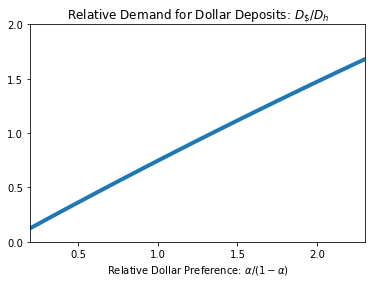

In [8]:
# number of points to be connected on the plots
m = 100

# 0.2 and 2.3 are the borders of alpha / (1 - alpha) on Figure 9
a_min = 0.2
a_max = 2.3

# 0 and 2 are borders of D_S / D_h on Figure 9 (on both plots)
d_min = 0
d_max = 2

# as we mentioned above, alpha_vec should be row vector with a shape (1, m)
alpha_div_1_minus_alpha_vec = np.reshape(np.linspace(a_min, a_max, m), newshape=(1, -1))
alpha_vec = alpha_div_1_minus_alpha_vec / (1 + alpha_div_1_minus_alpha_vec)  # this is t / (1 + t)

D_S_div_D_h_1_vec = D_S_div_D_h_fun(eps_vec, gamma, W, alpha_vec, Q_h, Q_S)

plt.plot(alpha_div_1_minus_alpha_vec.ravel(), D_S_div_D_h_1_vec, linewidth=4)

plt.xlabel(r"Relative Dollar Preference: $ \alpha/(1-\alpha) $")
plt.title(r"Relative Demand for Dollar Deposits: $ D_\$/D_h $")
plt.xlim(a_min, a_max)
plt.ylim(d_min, d_max)
plt.xticks([0.5, 1, 1.5, 2])
plt.yticks([0, 0.5, 1, 1.5, 2])

plt.show()

Awesome, our plot is exactly the same as in Figure 9! We are on the right way.  Now we will replicate the second plot of Figure 9. Note that $ D_{\$}/D_h $ is not exactly the function of $ Q_h/Q_{\$} $ (in a typical sense), but for a constant $ Q_{\$} $ (for example) $ D_{\$}/D_h $ is increasing in $ Q_h $. Thus, let us fix $ Q_{\$}=0.9 $ (as before) and make a splitting for $ Q_h $ (and after that we will repeat the same process for $ Q_{\$}=3\cdot0.9=2.7 $ to make sure that the function has changed, but monotonicity has not).

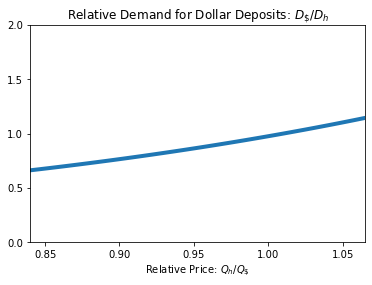

In [9]:
# 0.84 and 1.065 are the borders of Q_h / Q_S on Figure 9
q_min = 0.84
q_max = 1.065

# as we mentioned above, Q_h_vec should be row vector with a shape (1, m)
Q_h_vec = np.reshape(np.linspace(q_min * Q_S, q_max * Q_S, m), newshape=(1, -1))

# note that here we use a fixed alpha = 0.5
D_S_div_D_h_2_vec = D_S_div_D_h_fun(eps_vec, gamma, W, alpha, Q_h_vec, Q_S)

plt.plot((Q_h_vec / Q_S).ravel(), D_S_div_D_h_2_vec, linewidth=4)

plt.xlabel(r"Relative Price: $ Q_h/Q_{\$} $")
plt.title(r"Relative Demand for Dollar Deposits: $ D_\$/D_h $")
plt.xlim(q_min, q_max)
plt.ylim(d_min, d_max)
plt.xticks([0.85, 0.9, 0.95, 1, 1.05])
plt.yticks([0, 0.5, 1, 1.5, 2])

plt.show()

Looks exactly like on Figure 9! But if we change $ Q_{\$} $ to $ 2.7 $, the plot will be different, but most importantly, it will still be increasing function:

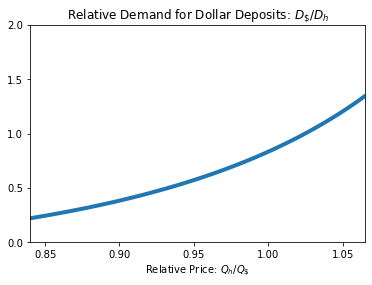

In [10]:
Q_S_new = 2.7
Q_h_new_vec = np.reshape(np.linspace(q_min * Q_S_new, q_max * Q_S_new, m), newshape=(1, -1))

D_S_div_D_h_3_vec = D_S_div_D_h_fun(eps_vec, gamma, W, alpha, Q_h_new_vec, Q_S_new)

plt.plot((Q_h_new_vec / Q_S_new).ravel(), D_S_div_D_h_3_vec, linewidth=4)

plt.xlabel(r"Relative Price: $ Q_h/Q_{\$} $")
plt.title(r"Relative Demand for Dollar Deposits: $ D_\$/D_h $")
plt.xlim(q_min, q_max)
plt.ylim(d_min, d_max)
plt.xticks([0.85, 0.9, 0.95, 1, 1.05])
plt.yticks([0, 0.5, 1, 1.5, 2])

plt.show()

OK, enough for Figure 9. Let us move to the replication of Figure 10. The banking sector in our problem is the same as in Section 2.2:
$$
\max\limits_{B_h,B_{\$},B_R}\mathbb{E}_0\left[\gamma N - B_h - B_{\$}-\xi B_R\right],
$$
subject to,
$$
Q_hB_h+Q_{\$}B_{\$}+Q_RB_R\ge N,
$$
$$
\bar{\mathcal{E}}B_{\$}+B_h\le \gamma_L N.
$$

We will not write here the meaning of the parameters as they are perfectly described in the paper. Let us concentrate on the mathematical calculations. 

Let $ \lambda $ and $ \mu $ be the Lagrange multipliers on the constraints above, respectively. The first-order conditions for the problem imply:
$$
Q_{\$}=\dfrac{\mu \bar{\mathcal{E}} + 1}{\lambda},
$$
$$
Q_h = \dfrac{\mu + 1}{\lambda},
$$
$$
Q_R=\dfrac{1}{\lambda}.
$$

Remember that in our problem there are risk-neutral investors (pages 48-49) and from their problem it follows that $ Q_R = \beta $. Thus, $ \dfrac{1}{\lambda}=\beta $ implying $ Q_{\$}-\beta=\beta\mu\bar{\mathcal{E}} $ and $ Q_{h}-\beta=\beta\mu $. Firstly, consider the internal solution case (when $ B_{\$}>0 $, $ \bar{\mathcal{E}}B_{\$}+B_h= \gamma_L N $ and $ \mu\ne0 $). In this case we can divide $ Q_{\$}-\beta $ by $ Q_h-\beta $ and derive the following equation:
\begin{equation} \label{eqn::internal_sol} \tag{1}
\dfrac{Q_{\$}-\beta}{Q_h-\beta}=\bar{\mathcal{E}}.
\end{equation}

But note that in the border case, when $ B_{\$}=0 $, the equation (1) is not correct (because $ \mu=0 $).

Let us move to the market clearing conditions: $ D_{\$}=B_{\$}+X $, $ D_h=B_h $. Thus, assuming that the safe asset constraint binds,
\begin{equation}
\bar{\mathcal{E}}B_{\$}+B_h= \gamma_L N\Leftrightarrow \bar{\mathcal{E}}\left(D_{\$}-X\right)+B_h= \gamma_L N\Leftrightarrow D_h=\gamma_L N + \bar{\mathcal{E}}\left(X-D_{\$}\right).
\label{eqn::safe_asset} \tag{2}
\end{equation}

We also derived above that
\begin{equation}
D_{\$}=\dfrac{W\theta}{Q_{\$}}
\label{eqn::D_S_eq} \tag{3}
\end{equation}
and
\begin{equation}
D_h=\dfrac{W(1-\theta)}{Q_h}.
\label{eqn::D_h_eq} \tag{4}
\end{equation}

So, we have two cases:
- internal solution, in which there is a system of four equations (1)-(4);
- border solution, in which $ B_{\$}=D_{\$}-X=0 $ implying $ D_{\$}=X $, which (with the equation (2)) entails that $ D_h=\gamma_L N $, and these in sum imply the system of two equations (5)-(6):
\begin{equation}
X=\dfrac{W\theta}{Q_{\$}}
\label{eqn::border_1} \tag{5}
\end{equation}
and
\begin{equation}
\gamma_L N=\dfrac{W(1-\theta)}{Q_h}.
\label{eqn::border_2} \tag{6}
\end{equation}

Let us first find the internal solution by solving the first system for the variables $ D_{\$}, D_h, Q_{\$}, Q_h $ as functions of $ \alpha $. Note that $ \theta $ is already a function of $ \alpha, Q_h, Q_{\$} $ (given $ \gamma, W $ and the vector of values of $ \mathcal{E}_1 $ fixed). Let us implement it in code:

In [11]:
# from now on all calculations won't be vectorized since 
# we will use function root finders (solvers) which cannot handle vector input, 
# so we won't note output shapes anymore

# note that we won't use W, gamma and eps_vec as function parameters anymore and we will consider them 
# as global variables defined above (it is reasonable since we won't change them and we also have a lot of variables)

theta_tmp2_fun = lambda alpha, Q_h, Q_S: theta_tmp1_fun(eps_vec, gamma, W, alpha, Q_h, Q_S)

From (1) it follows that $ Q_{\$}=Q_{\$}(Q_h)=\beta+\bar{\mathcal{E}}\left(Q_h-\beta\right) $. Let us implement this in code as well:

In [12]:
Q_S_fun = lambda Q_h, beta, eps_max: beta + eps_max * (Q_h - beta)

Now we can rewrite $ \theta $ as a function of only $ \alpha $ and $ Q_h $ (and some parameters which will later be initialized):

In [13]:
theta_fun = lambda alpha, Q_h, beta, eps_max: theta_tmp2_fun(alpha, Q_h, Q_S_fun(Q_h, beta, eps_max))

In equations (2) and (4) the left side is the same and equals $ D_h $. Let us equate the right sides:
$$
\dfrac{W(1-\theta)}{Q_h}=\gamma_L N + \bar{\mathcal{E}}(X-D_{\$}).
$$

Now substitute $ D_{\$} $ from equation (3) into the previous formula and move everything to the left:
\begin{equation}
\dfrac{W(1-\theta)}{Q_h}-\gamma_L N-\bar{\mathcal{E}}\left(X-\dfrac{W\theta}{Q_{\$}}\right)=0.
\end{equation}

So, what did we get? We got an equation in the form $ F(\alpha, Q_h)=0 $ (where $ \theta $ and $ Q_{\$} $ are expressed as a functions of $ \alpha $ and $ Q_h $ above; more accurately, $ Q_{\$} $ is a function of only $ Q_h $ so far), given the parameters $ W, \gamma, \gamma_L, N, X $ and the values of $ \mathcal{E}_1 $ including the maximum value $ \bar{\mathcal{E}} $ fixed. Thus, for a given $ \alpha $ we can find a corresponding value of $ Q_h $ solving the equation $ F(\alpha, Q_h)=0 $. The function $ F $ which we are going to find a root for is implemented in the following code:

In [14]:
def F_opt_fun(alpha, Q_h, beta, eps_max, gamma_L, N, X):
    theta = theta_fun(alpha, Q_h, beta, eps_max)
    return W * (1 - theta) / Q_h - gamma_L * N - eps_max * (X - W * theta / Q_S_fun(Q_h, beta, eps_max))

Now we can find $ Q_h $ as a function of $ \alpha $ (using a method described in the previous cell). We start our search in $ Q_h=1 $ and use Levenberg-Marquardt method (`lm` in code):

In [15]:
Q_h_fun = lambda alpha, beta, eps_max, gamma_L, N, X: \
    root(lambda Q_h: F_opt_fun(alpha, Q_h, beta, eps_max, gamma_L, N, X), [1,], method='lm').x[0]

We got $ Q_h $ as a function of $ \alpha $. Thus, using $ Q_{\$}=Q_{\$}(Q_h)=\beta+\bar{\mathcal{E}}\left(Q_h-\beta\right) $, we can derive $ Q_{\$} $ for the same $ \alpha $. After that we can find $ \theta $ for this $ \alpha $. Finally, using equations (3) and (4) we can find $ D_{\$} $ and $ D_h $. Thus, the internal solution is found.

Secondly, let us find the value of $ \alpha $ which is a border value for the internal solution. This value is such that $ B_{\$}=D_{\$}-X=0 $ (being $ >0 $ for the values to the right of this value of $ \alpha $). We already found $ D_{\$} $ as a function of $ \alpha $ in the internal solution, and the border value $ \bar{\alpha} $ is such that $ D_{\$}(\bar{\alpha})-X=0 $. Let us find this value (and now it will be a function of parameters which will be initialized a bit later):

In [16]:
def alpha_opt_fun(alpha, beta, eps_max, gamma_L, N, X):
    # find Q_h for a given alpha
    Q_h = Q_h_fun(alpha, beta, eps_max, gamma_L, N, X)
    # find Q_S for the same alpha
    Q_S = Q_S_fun(Q_h, beta, eps_max)
    
    # find theta for the same alpha
    theta = theta_fun(alpha, Q_h, beta, eps_max)
    
    # find D_S for the same alpha
    D_S = W * theta / Q_S
    # the function to find a root of is D_S(alpha) - X
    return D_S - X

# here we simply find roots of the function written above (start with alpha=0.2 and use the same method as before)
alpha_border_fun = lambda beta, eps_max, gamma_L, N, X: \
    root(lambda alpha: alpha_opt_fun(alpha, beta, eps_max, gamma_L, N, X), [0.2,], method='lm').x[0]

Finally, let us find the border solution (solving the system (5)-(6)). We will do that directly:

For a given $ \alpha<\bar{\alpha} $
- find $ \theta $ as a function of $ Q_h, Q_{\$} $;
- substitute it to the system (5)-(6) getting a system of two equations and two variables $ Q_h, Q_{\$} $;
- solve that system.

In the following code we will do that for any fixed values of $ D_h $ and $ D_{\$} $ (thus, solving (3) and (4)), but later we will substitute the values $ D_{\$}=X $ and $ D_h=\gamma_L N $ to the found functions $ Q_h(D_h, D_{\$}, \alpha) $ and $ Q_{\$}(D_h, D_{\$}, \alpha) $.

In [17]:
def Q_h_Q_S_ext_opt_fun(alpha, Q_h, Q_S, D_h, D_S):
    # find theta for a given alpha, Q_h and Q_S
    theta = theta_tmp2_fun(alpha, Q_h, Q_S)[0]
    
    # to solve the system, we move everything to the left and equate it to zero
    return [W * theta / Q_S - D_S, W * (1 - theta) / Q_h - D_h]

# note that in the root() the function should be dependend of one vectorized variable, 
# so we moved Q_h and Q_S into Q_h_Q_S_vec
# initial values for a search are 1 and 1, and the method is the same as before
Q_h_Q_S_ext_vec_fun = lambda alpha, D_h, D_S: \
    root(lambda Q_h_Q_S_vec: Q_h_Q_S_ext_opt_fun(alpha, Q_h_Q_S_vec[0], Q_h_Q_S_vec[1], D_h, D_S), 
         [1, 1], method='lm').x

Now let us initialize our parameters (values are taken from the page 51). Remember that $ \bar{\mathcal{E}} $ is simply a maximum possible value of $ \mathcal{E}_1 $ (in our casse it is $ 1.3 $).

In [18]:
N = 4.5
X = 0.8
beta = 0.75
gamma_L = 0.6

eps_max = np.max(eps_vec)

Next let us find the exact border value of $ \alpha $:

In [19]:
alpha_border = alpha_border_fun(beta, eps_max, gamma_L, N, X)
print(f"Border value of alpha is {alpha_border:.3f}.")

Border value of alpha is 0.248.


It seems that we found the right value (comparing to Figure 10)! Now everything is prepared to find $ Q_{\$}-Q_h $ and $ B_{\$} $ as functions of $ \alpha $!

In [20]:
# we will use this function in the loop with scalar alpha, so we needn't worry about shapes
# we will find both Q_S - Q_h and B_S in the same function
def Q_S_minus_Q_h_and_B_S_fun(alpha):
    if alpha >= alpha_border:
        # the internal solution
        Q_h = Q_h_fun(alpha, beta, eps_max, gamma_L, N, X)
        Q_S = Q_S_fun(Q_h, beta, eps_max)

        theta = theta_fun(alpha, Q_h, beta, eps_max)

        D_S = W * theta / Q_S
        D_h = W * (1 - theta) / Q_h

        B_S = D_S - X

    else:
        # the border solution
        D_S = X
        D_h = gamma_L * N
        
        B_S = 0
        
        Q_h, Q_S = Q_h_Q_S_ext_vec_fun(alpha, D_h, D_S)
    return Q_S - Q_h, B_S

Finally, to replicate Figure 10, we should create a splitting for $ \alpha $ and find the values for $ Q_{\$}-Q_h $ and $ B_{\$} $ in the loop:

In [21]:
# 0.16 and 0.7 are the borders of alpha on Figure 10
a_min = 0.16
a_max = 0.7

alpha_vec = np.linspace(a_min, a_max, m)

Q_S_minus_Q_h_vec = np.empty(shape=m)
B_S_vec = np.empty(shape=m)

for (i, alpha) in enumerate(alpha_vec):
    Q_S_minus_Q_h_vec[i], B_S_vec[i] = Q_S_minus_Q_h_and_B_S_fun(alpha)

Now we are ready to plot!

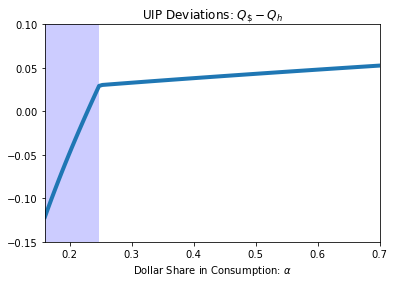

In [22]:
# -0.15 and 0.1 are the borders of Q_S - Q_h on Figure 10
q_min = -0.15
q_max = 0.1

plt.plot(alpha_vec, Q_S_minus_Q_h_vec, linewidth=4)

plt.xlabel(r"Dollar Share in Consumption: $ \alpha $")
plt.title(r"UIP Deviations: $ Q_{\$}-Q_h $")
plt.xlim(a_min, a_max)
plt.ylim(q_min, q_max)
plt.xticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.yticks([-0.15, -0.1, -0.05, 0, 0.05, 0.1])

# here we fill the area of border solution (alpha < alpha_border)
plt.fill_between([a_min, alpha_border], q_min, q_max, facecolor='blue', alpha=0.2)

plt.show()

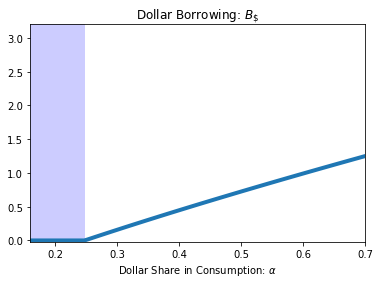

In [23]:
# 0 and 3.2 are the borders of B_S on Figure 10
b_min = 0
b_max = 3.2

# we use b_min - 2e-2 below to be able to see the zero line (and a part of the curve) in border solution area
plt.plot(alpha_vec, B_S_vec, linewidth=4)

plt.xlabel(r"Dollar Share in Consumption: $ \alpha $")
plt.title(r"Dollar Borrowing: $ B_{\$} $")
plt.xlim(a_min, a_max)
plt.ylim(b_min - 2e-2, b_max)
plt.xticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.yticks([0, 0.5, 1, 1.5, 2, 2.5, 3])

# here we fill the area of border solution (alpha < alpha_border)
plt.fill_between([a_min, alpha_border], b_min - 2e-2, b_max, facecolor='blue', alpha=0.2)

plt.show()

Hooray, our plots are exactly the same as in Figure 10 from the paper! I feel relieved.